1. Missing values
==


In the machine learning workflow, once we've selected the model we want to use, selecting the appropriate features for that model is the next important step. In this mission, we'll explore how to use correlation between features and the target column, correlation between features, and variance of features to select features. We'll continue working with the same housing dataset from the last mission.

We'll specifically focus on selecting from feature columns that don't have any missing values or don't need to be transformed to be useful (e.g. columns like **Year Built** and **Year Remod/Add**). We'll explore how to deal with both of these in a later mission in this course.

To start, let's look at which columns fall into either of these two categories.

In [6]:
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter="\t")

train = data[0:1460]
test = data[1460:]

numerical_train = train.select_dtypes(include=['int', 'float'])
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add', 
                                        'Garage Yr Blt', 'Mo Sold', 'Yr Sold'], axis=1)

null_series = numerical_train.isnull().sum()
full_cols_series = null_series[null_series == 0]
full_cols_series

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64

2. Correlating Feature Columns With Target Column
==

In the last mission, we selected the feature for the simple linear regression model by comparing how some of the features correlate with the target column. If you recall, we focused on 4 features in particular and used the **pandas.DataFrame.corr()** method to return the correlation coefficients between each pairs of columns. This means that the correlation matrix for 4 columns results in 16 correlation values:


In [8]:
train[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr()

,Garage Area,Gr Liv Area,Overall Cond,SalePrice
Garage Area,1.000000,0.465366,-0.132401,0.662397
Gr Liv Area,0.465366,1.000000,-0.133710,0.698990
Overall Cond,-0.132401,-0.133710,1.000000,-0.099395
SalePrice,0.662397,0.698990,-0.099395,1.000000


The subset of features we want to focus on, **full_cols_series**, contains 25 columns:

In [9]:
len(full_cols_series)

25

The resulting correlation matrix will contain 25 x 25 or 625 correlation values. Comparing and contrasting this many values is incredibly difficult. Let's instead focus on just how the feature columns correlate with the target column (**SalePrice**) instead.

In [11]:
train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64


3. Correlation Matrix Heatmap
==

We now have a decent list of candidate features to use in our model, sorted by how strongly they're correlated with the **SalePrice** column. For now, let's keep only the features that have a correlation of **0.3** or higher. This cutoff is a bit arbitrary and, in general, it's a good idea to experiment with this cutoff. For example, you can train and test models using the columns selected using different cutoffs and see where your model stops improving.

The next thing we need to look for is for potential **collinearity** between some of these feature columns. Collinearity is when 2 feature columns are highly correlated and stand the risk of duplicating information. If we have 2 features that convey the same information using 2 different measures or metrics, we don't need to keep both.

While we can check for collinearity between 2 columns using the correlation matrix, we run the risk of information overload. We can instead generate a [correlation matrix heatmap](http://seaborn.pydata.org/examples/heatmap_annotation.html) using Seaborn to visually compare the correlations and look for problematic pairwise feature correlations. Because we're looking for outlier values in the heatmap, this visual representation is easier.

Here's what the example correlation matrix heatmap looks like from the documentation:

<img width="450" alt="creating a repo" src="https://drive.google.com/uc?export=view&id=11v5f5BaFC2OhRM4bAVT1CzjxGws5jGPZ">


To generate a correlation matrix heatmap, we need to pass in the data frame containing the correlation matrix as a data frame into the **seaborn.heatmap()** function.

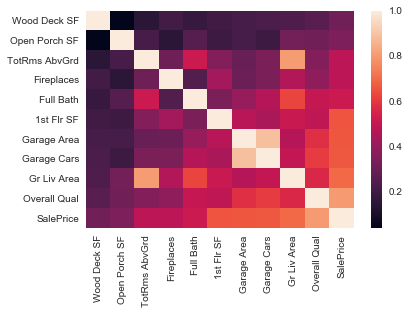

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

strong_corrs = sorted_corrs[sorted_corrs > 0.3]
corrmat = train_subset[strong_corrs.index].corr()
sns.heatmap(corrmat)

plt.show()

4. Train And Test Model
==

Based on the correlation matrix heatmap, we can tell that the following pairs of columns are strongly correlated:

- **Gr Liv Area** and **TotRms AbvGrd**
- **Garage Area** and **Garage Cars**

If we read the descriptions of these columns from the [data documentation](https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt), we can tell that each pair of column reflects very similar information. Bceause **Gr Liv Area** and **Garage Area** are continuous variables that capture more nuance, let's drop the **TotRms AbvGrd** and **Garage Cars**.

The last thing we'll need to do is confirm that the test set contains no missing values for these columns:


In [18]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
test[final_corr_cols.index].info()
##note: for train is ok (whitout missing values)!!!

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 1460 to 2929
Data columns (total 9 columns):
Wood Deck SF     1470 non-null int64
Open Porch SF    1470 non-null int64
Fireplaces       1470 non-null int64
Full Bath        1470 non-null int64
1st Flr SF       1470 non-null int64
Garage Area      1469 non-null float64
Gr Liv Area      1470 non-null int64
Overall Qual     1470 non-null int64
SalePrice        1470 non-null int64
dtypes: float64(1), int64(8)
memory usage: 103.4 KB


Looks like the test set has one pesky row with a missing value for **Garage Area**. Let's just drop this row for now. Finally, let's train and test a model using these columns to see how they fare.

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'
clean_test = test[final_corr_cols.index].dropna()

lr = LinearRegression()
lr.fit(train[features], train[target])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print(train_rmse)
print(test_rmse)

34173.9762919
41032.0261202


5. Removing Low Variance Features
==

The last technique we'll explore is removing features with low variance. When the values in a feature column have low variance, they don't meaningfully contribute to the model's predictive capability. On the extreme end, let's imagine a column with a variance of **0**. This would mean that all of the values in that column **were exactly the same**. This means that the column isn't informative and isn't going to help the model make better predictions.

To make apples to apples comparisons between columns, we need to rescale all of the columns to vary between **0** and **1**. Then, we can set a cutoff value for variance and remove features that have less than that variance amount. This is known as min-max scaling or as rescaling. Here's the formula for rescaling:

$$\frac{x−min(x)}{max(x)−min(x)}$$

Where:

- $x$ is an individual value
- $min(x)$ is the minimum value for the column $x$ belongs to
- $max(x)$ is the maximum value for the column $x$ belongs to

In [20]:
unit_train = (train[features] - train[features].min())/(train[features].max() - train[features].min())
print(unit_train.min())
print(unit_train.max())
# Confirmed: the min and max values are 0.0 and 1.0 respectively

sorted_vars = unit_train.var().sort_values()
print(sorted_vars)

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64
Open Porch SF    0.013938
Full Bath        0.018621
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
1st Flr SF       0.025814
Wood Deck SF     0.033064
Fireplaces       0.046589
dtype: float64


6. Final Model
==

To wrap up this mission, let's set a cutoff variance of **0.015**, remove the **Open Porch SF feature**, and train and test a model using the remaining features.


In [21]:
clean_test = test[final_corr_cols.index].dropna()
features = features.drop('Open Porch SF')

lr = LinearRegression()
lr.fit(train[features], train[target])

train_predictions = lr.predict(train[features])
test_predictions = lr.predict(clean_test[features])

train_mse = mean_squared_error(train_predictions, train[target])
test_mse = mean_squared_error(test_predictions, clean_test[target])

train_rmse_2 = np.sqrt(train_mse)
test_rmse_2 = np.sqrt(test_mse)

print(train_rmse_2)
print(test_rmse_2)

34372.6967078
40591.4270244


7. Next steps
==

We were able to improve the RMSE value to approximately **40591** by removing the **Open Porch SF** feature. This is most likely the furthest we can go without transforming and utilizing the other features in the dataset so we'll stop here for now. In the next 2 missions, we'll explore 2 different ways of fitting models. Afterwards, we'll explore ways to clean and engineer new features from the existing features to improve model accuracy even further.
